In [3]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import gzip
import simplejson
import json
import time
import scipy.spatial
import pickle

from sklearn.feature_extraction import DictVectorizer
from keras.preprocessing.text import text_to_word_sequence


Using TensorFlow backend.


In [4]:
import codecs
import os
from keras.preprocessing.text import Tokenizer as tokenizer

# utils
def initEmbeddingMap(fileName='glove.6B.50d.txt'):
    embedding_map = {}
    BASE_DIR = ''
    GLOVE_DIR = os.path.join(BASE_DIR, 'data/glove.6B')
    glove = open(os.path.join(GLOVE_DIR, fileName))
    
    print('constructing embedding dictionary')
    embedding_map = {}
    for line in glove:
        values = line.split()
        word = values[0]
        value = np.asarray(values[1:], dtype='float32')
        embedding_map[word] = value
    glove.close()
    return embedding_map

def clean(text):
    return text_to_word_sequence(text, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                                 lower=True, split=" ")


# returns dict with users and movies they rated as repeated rows
# cleans review text and add to rawOutput
def initRawData(input_file, save=False):
    print('initializing raw data')
    rawInputData = []
    rawOutputData = []
    with open(input_file,'r') as f:
        for i in f:
            line = f.readline()
            if len(line) < 4:
                break
            lineObj = json.loads(line)
            user = lineObj['reviewerID']
            item = lineObj['asin']
            rawInputDataObj = {'user':user, 'asin':item}
            rawOutputDataObj = clean(lineObj['reviewText'])
            rawInputData.append(rawInputDataObj)
            rawOutputData.append(rawOutputDataObj)
#     if save:
#         pickle.dump((rawInputData, rawOutputData), open(fileName,'wb'))
    return rawInputData, rawOutputData

# creates dict of usrs w/ all movies rated + movies w/ all user ratings *** 
def group_data(inputData):
    users = {}
    items = {}
    for datum in inputData:
        u = datum['user']
        i = datum['asin']
        users.setdefault(u, []).append(i)
        items.setdefault(i, []).append(u)
    return (users, items)

# utils - doesnt seem necessary
def getSetFromData(key, data):
    result = set()
    for datum in data:
        result.add(datum.get(key))
    return result

def seq_2_matrix(sequence, embedding_map):
    m = []
    for word in sequence:
        emb = embedding_map.get(word)
        if emb is not None:
            m.append(emb)
    return np.array(m)

def matrix_2_avg(emb_matrix):
    return np.mean(emb_matrix, 0)


# utils - one hot encodes all data 
def initVecData(rawInputData, rawOutputData, embedding_map):
    print('initializing vectorized data')
    dictVect = DictVectorizer()
    vecInputData = dictVect.fit_transform(rawInputData).toarray()
    vecOutputData = [matrix_2_avg(seq_2_matrix(review, embedding_map)) for review in rawOutputData]
#     if save:
#         pickle.dump((vecInputData, vecOutputData), open(fileName,'wb'))
    return vecInputData, vecOutputData

def initMatInputData(rawInputData, rawOutputData, embedding_map, save=False):
    print('initializing matrix data')
    if len(rawInputData) != len(rawOutputData):
        raise ValueError("Need same size of input and output")
    users = {}
    extra_info = {}
    items = {}
    dictVect = DictVectorizer()
    for i in range(len(rawInputData)):
        vecOutput = seq_2_matrix(rawOutputData[i], embedding_map)
        rawInput = rawInputData[i]
        user = rawInput['user']
        item = rawInput['asin']
        users.setdefault(user, []).append(vecOutput)
        items.setdefault(item, []).append(vecOutput)
        
    matUserInputData = []
    matItemInputData = []
    users = {k: np.vstack(v) for k, v in users.items()}
    items = {k: np.vstack(v) for k, v in items.items()}
    extra_info['user_seq_sizes'] = [m.shape[0] for m in users.values()]
    extra_info['item_seq_sizes'] = [m.shape[0] for m in items.values()]
    for i in range(len(rawInputData)):
        rawInput = rawInputData[i]
        user = rawInput['user']
        item = rawInput['asin']
        matUserInputData.append(users.get(user))
        matItemInputData.append(items.get(item))
#     if save:
#         pickle.dump((matUserInputData, matItemInputData), open(fileName,'wb'))
    return matUserInputData, matItemInputData, extra_info

def toKey(user, item):
    return (user, item)

def initRatingsOutputData(rawInputData, input_file, save=False):
    ratingsData = []
    userItemDict = {}
    for i in range(len(rawInputData)):
        rawInput = rawInputData[i]
        userItem = toKey(rawInput['user'], rawInput['asin'])
        userItemDict[userItem] = i
        ratingsData.append(None) # check later to make sure no Nones left
        
    with open(input_file,'r') as f:
        for i in f:
            line = f.readline()
            lineObj = json.loads(line)
            user = lineObj['reviewerID']
            item = lineObj['asin']
            rating = lineObj['overall']
            #rating = float(terms[2]) / 2.5 - 1.0
            i = userItemDict.get(toKey(user, item))
            if i is not None:
                ratingsData[i] = rating
        failure = None in ratingsData
        if failure:
            raise ValueError(str(len([r for r in ratingsData if r is None])) + " reviews did not have corresponding rating.")
#     if save:
#         pickle.dump(ratingsData, open(fileName,'wb'))
    return ratingsData

# Text Preprocessing Examples

**_initRawData( )_** - returns rawInputData and rawOutputData.

**_rawInputData:_** List of dicts where each dict is a userID and movieID grouping. Groupings are unqiue but a user 
or movie can/do repeat if multiple users have reviewed a particular movie
    
**_rawOutputData:_** List of lists where each sub list is text from a unique review. The reviews correspond to the
user/movie key pairs in rawInputData

In [5]:
fileName = "data/reviews_Amazon_Instant_Video_5.json"
rawInputData, rawOutputData = initRawData(input_file=fileName, save=False)
print("Number of user/item data:", len(rawInputData))
print("Number of reviews:", len(rawOutputData))
print()
print(rawInputData[0:5])
print()
print(rawOutputData[0])
print()
print(rawOutputData[1])

initializing raw data
Number of user/item data: 18563
Number of reviews: 18563

[{'user': 'A3BC8O2KCL29V2', 'asin': 'B000H00VBQ'}, {'user': 'A1RJPIGRSNX4PW', 'asin': 'B000H00VBQ'}, {'user': 'A1POFVVXUZR3IQ', 'asin': 'B000H00VBQ'}, {'user': 'ATASGS8HZHGIB', 'asin': 'B000H0X79O'}, {'user': 'AUX8EUBNTHIIU', 'asin': 'B000H0X79O'}]

['i', 'highly', 'recommend', 'this', 'series', 'it', 'is', 'a', 'must', 'for', 'anyone', 'who', 'is', 'yearning', 'to', 'watch', 'grown', 'up', 'television', 'complex', 'characters', 'and', 'plots', 'to', 'keep', 'one', 'totally', 'involved', 'thank', 'you', 'amazin', 'prime']

['mysteries', 'are', 'interesting', 'the', 'tension', 'between', 'robson', 'and', 'the', 'tall', 'blond', 'is', 'good', 'but', 'not', 'always', 'believable', 'she', 'often', 'seemed', 'uncomfortable']


**_group-data( )_** - returns dicts of userID/movieID and movieID/userID groups

**_users:_** Dict where each userID key has a corresponding list of movieID they've' reviewed
    
**_movies:_** Dict where each movieID key has all the userIDs of reviews

In [6]:
users, movies = group_data(rawInputData)
print("All movies userID 'A3BC8O2KCL29V2' has seen:\n", users['A3BC8O2KCL29V2'])
print()
print("All userIDs of watches of movie 'B00F0CLHQO':\n", movies['B00F0CLHQO'])
print()
print("Number of movies:", len(movies))
print("Number of users:", len(users))

All movies userID 'A3BC8O2KCL29V2' has seen:
 ['B000H00VBQ', 'B00F0CLHQO', 'B00I3MMN4I']

All userIDs of watches of movie 'B00F0CLHQO':
 ['A3BC8O2KCL29V2', 'A821GRKOLGILD', 'AGTOYPUYZCCWN', 'AXO4PQU0XG3TG', 'A2LCOSYZL96HHA', 'A328S9RN3U5M68', 'AGUN5F2W85777', 'A1WXOTZHDNAV0Q', 'A3QLAOOTFEHCJI', 'A1TPW86OHXTXFC', 'AFVHO52P7IMPG', 'A18758S1PUYIDT']

Number of movies: 1685
Number of users: 5033


**Randomize the data**

In [7]:
rand_idxs = np.random.permutation(len(rawOutputData))
print("Randomized index list:", rand_idxs)
print("Total number of rand_indxs:", len(rand_idxs))
rawInputData = [rawInputData[i] for i in rand_idxs]
rawOutputData = [rawOutputData[i] for i in rand_idxs]

Randomized index list: [ 6197  9171 11547 ..., 14792   364 18251]
Total number of rand_indxs: 18563


**Get Embedding Matrix **

Uses GloVe 50d (100d, 300d) pre-trained embedding to create a giant word dict of possible words.
We then use this matrix to create encodings of movie reviews 

__requires__: GloVe Embeddings to be downloaded - http://nlp.stanford.edu/data/glove.6B.zip

In [8]:
embedding_map = initEmbeddingMap()

constructing embedding dictionary


**_getSetFromData( )_**: Gets list of unique userID or unique movieID from data

**_initVecData( )_**: Returns vectorized versions _InputData_ and dense encodings of review text using embedding matrix

**_vecInputData_**: 
Is rawInputData dict of 18563 samples of userID to movieID, converted to one-hot encoding of where first 5033 col represent user encodings and remaining represent 1685 movieIDs

**_vecOutputData_**: 
Is rawOutputData list of reviews seperated into words where each 
word in the review is swapped for it's embedding representation i.e.
1x50 row per word. These rows are turn into a matrix of words x 50 dims
then you take mean of each col to get a 1x50 array (why?). These arrays
are returned for each  18563 sample yielding a 18563x50 list matrix

**_vecUsers_**:
Why like this? Unclear... dimesions are strange but seems to be required in factorization machine

**_vecMovies_**:
Why like this? Unclear... dimesions are strange but seems to be required in factorization machine

In [14]:
all_users = getSetFromData('user', rawInputData)
all_movies = getSetFromData('asin', rawInputData)
vecInputData, vecOutputData = initVecData(rawInputData, rawOutputData, embedding_map)
vecUsers = vecInputData[:,len(all_users):] 
vecMovies = vecInputData[:,:len(all_movies)]

print("Shape of matrix vecInputData: {}".format(vecInputData.shape))
print("Shape of list vecOutputData: ({}, {})".format(len(vecOutputData), len(vecOutputData[0])))

print(vecUsers.shape)
print(vecMovies.shape)


initializing vectorized data
Shape of matrix vecInputData: (18563, 6718)
Shape of list vecOutputData: (18563, 50)
(18563, 1685)
(18563, 1685)


In [15]:
vecInputData.shape

(18563, 6718)

**_initMatInputData_**: Creates dense encodings UserID/MovieID data and text review data

In [21]:
matUserInputData, matMovieInputData, extra_info = initMatInputData(rawInputData, rawOutputData, embedding_map)
#print(len(matUserInputData))
#print(len(matMovieInputData))
print(matUserInputData[0:1])
print()



initializing matrix data
[array([[  5.50249994e-01,  -2.49420002e-01,  -9.38599987e-04, ...,
          3.37630004e-01,   5.01389988e-02,   3.34650010e-01],
       [  6.80469990e-01,  -3.92629988e-02,   3.01860005e-01, ...,
         -7.32970014e-02,  -6.46990016e-02,  -2.60439992e-01],
       [  3.68079990e-01,   2.08340004e-01,  -2.23189995e-01, ...,
         -6.72360003e-01,  -3.97089988e-01,   2.51830012e-01],
       ..., 
       [  3.30419987e-01,   2.49950007e-01,  -6.08739972e-01, ...,
         -5.07030010e-01,  -2.72729993e-02,  -5.32850027e-01],
       [  5.30740023e-01,   4.01169986e-01,  -4.07849997e-01, ...,
          2.87620008e-01,   1.44400001e-01,   2.36110002e-01],
       [ -3.11500013e-01,   5.29200017e-01,  -1.34570003e+00, ...,
         -7.68649995e-01,  -2.59369999e-01,   1.56680000e+00]], dtype=float32)]



In [24]:
print(matMovieInputData[1].shape)
rawInputData[1]

(4668, 50)


{'asin': 'B009JZTOG8', 'user': 'A1G2WFEXLVBPN'}

**_initRatingsOutputData( )_**: 
Index each unique key pair (usr/movie) in rawInputData then assigns the correct
rating to the ratings list based on that index of the key pair in dict userItemDict.
Returns list of scores ordered correctly



In [12]:
fileName = "data/reviews_Amazon_Instant_Video_5.json"
ratingsData = initRatingsOutputData(rawInputData, input_file=fileName,save=False)

print("Printing a few ratings...\n", ratingsData[0:20])
print()
print("Total ratings:", len(ratingsData))


Printing a few ratings...
 [4.0, 5.0, 5.0, 1.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 3.0, 5.0, 3.0, 5.0, 3.0, 1.0, 5.0, 5.0, 5.0, 4.0]

Total ratings: 18563


# Matrix Factorization Model

In [11]:
import matplotlib.pyplot as plt  

from keras.models import Model
from keras.layers import Input, Dense
from keras.layers.merge import Dot
from keras.callbacks import EarlyStopping
from keras import metrics
from keras import backend as K

**_create-factorization-model_**
Builds and compiles the factorization model which is essentially the row by row dot product of
user data with movie data. Returns Keras model

_Optimization_: Adam 

_Loss function_: Mean Squared Error

**_matrix-factorization_**:
Splits _vecUsers_ and _vecMovies_ into train/test splits and evaluates factorization-model given vecUser/vecMovie input data

_batch-size_: preset 32

_training-percent_: 90%

_epochs_: default 100

_earlystopping_: Set implementation

**_Evaluate_**:
Evaluates factorization model using MSE. Prints predictions vs true labels and shows plot


In [12]:
def create_factorization_model(user_size, item_size, hidden_size):
    inputU = Input(shape=(user_size,))
    inputI = Input(shape=(item_size,))
    hiddenU = Dense(hidden_size)(inputU)
    hiddenI = Dense(hidden_size)(inputI)
    dotproduct = Dot(axes=1)([hiddenU, hiddenI])
    model = Model(inputs=[inputU, inputI], outputs=[dotproduct])
    model.compile(optimizer='adam', loss='mse')
    return model

def matrix_factorization(vecUsers, vecMovies, ratingsData, hidden_size=4, epochs=100, training=0.9):
    model = create_factorization_model(vecUsers.shape[1], vecMovies.shape[1], hidden_size)

    trainingN = int(len(ratingsData) * training) if type(training) is float else training

    train_inputs = [vecUsers[:trainingN], vecMovies[:trainingN]]
    train_outputs = ratingsData[:trainingN]
    test_inputs = [vecUsers[trainingN:], vecMovies[trainingN:]]
    test_outputs = ratingsData[trainingN:]
    print(model.summary())

    early_stopping = EarlyStopping(monitor='loss', patience=8)
    early_stopping_val = EarlyStopping(monitor='val_loss', patience=12)
    batch_size = 32
    model.fit(train_inputs, train_outputs, validation_split=0.2, callbacks=[early_stopping, early_stopping_val], batch_size=batch_size, epochs=epochs)
    evaluate(model, train_inputs, train_outputs, test_inputs, test_outputs)

def evaluate(model, train_inputs, train_outputs, test_inputs, test_outputs):
    model_train_mse = model.evaluate(train_inputs, train_outputs, verbose=0)
    print("Printing a few test outputs...\n", test_outputs[0:20])
    print()
    baseline = np.mean(train_outputs)
    baseline_train_mse = np.mean((baseline - train_outputs) ** 2)
    print("baseline train mse: " + str(baseline_train_mse))
    print("model train mse: " + str(model_train_mse))
    print()

    model_test_mse = model.evaluate(test_inputs, test_outputs, verbose=1, batch_size=len(test_outputs))
    baseline_test_mse = np.mean((baseline - test_outputs) ** 2)
    print("baseline test mse: " + str(baseline_test_mse))
    print("model test mse: " + str(model_test_mse))


    predictions = model.predict(test_inputs, verbose=0)
    print("Printing a few predictions...\n", predictions[0:20])
    tf_session = K.get_session()
    print("MSE Test:", np.mean(metrics.mean_squared_error(predictions, test_outputs).eval(session=tf_session)))
    #print(np.mean((predictions - test_outputs) ** 2))
    jitter = lambda x : np.random.normal(x, np.std(x)/10) # Adds no it so we can see d
    plt.scatter(jitter(predictions), jitter(test_outputs))
    #plt.scatter(predictions, test_outputs)

    plt.show()

#### Training Factorization Model...

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1685)         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1685)         0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 4)            6744        input_7[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 4)            6744        input_8[0][0]                    
__________________________________________________________________________________________________
dot_4 (Dot

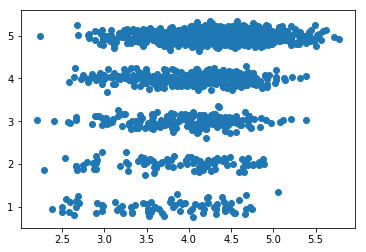

In [49]:
matrix_factorization(vecUsers, vecItems, ratingsData, epochs=10, training=.9)

# DeepCoNN Recommendation Model

### Need to add comments but brain is fried...

In [13]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers.merge import Add, Dot, Concatenate
from keras.preprocessing.sequence import pad_sequences

In [14]:
class DeepCoNN():
    def __init__(self, embedding_size, hidden_size, u_seq_len, m_seq_len, filters=2, kernel_size=8, strides=6):
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.filters = filters
        self.kernel_size = kernel_size
        self.inputU, self.towerU = self.create_deepconn_tower(u_seq_len)
        self.inputM, self.towerM = self.create_deepconn_tower(m_seq_len)
        self.joined = Concatenate()([self.towerU, self.towerM])
        self.outNeuron = Dense(1)(self.joined)

    def create_deepconn_tower(self, max_seq_len):
        input_layer = Input(shape=(max_seq_len, self.embedding_size))
        tower = Conv1D(filters=self.filters, kernel_size=self.kernel_size, activation="relu")(input_layer)
        tower = MaxPooling1D()(tower)
        tower = Flatten()(tower)
        tower = Dense(self.hidden_size, activation="relu")(tower)
        return input_layer, tower

    def create_deepconn_dp(self):
        dotproduct = Dot(axes=1)([self.towerU, self.towerM])
        output = Add()([self.outNeuron, dotproduct])
        model = Model(inputs=[self.inputU, self.inputM], outputs=[output])
        model.compile(optimizer='Adam', loss='mse')
        return model

In [15]:
def build_DeepcoNN(matUserInputData, matItemInputData, ratingsData, u_seq_len=200, i_seq_len=200, hidden_size=4, epochs=3500, training=None):
    embed_dims = matUserInputData[0].shape[1]
    deepconn = DeepCoNN(embed_dims, hidden_size, u_seq_len, i_seq_len)

    model = deepconn.create_deepconn_dp()

    user_input = pad_sequences(np.asarray(matUserInputData), maxlen=u_seq_len)
    item_input = pad_sequences(np.asarray(matItemInputData), maxlen=i_seq_len)

    trainingN = int(len(user_input) * training) if type(training) is float else training

    inputs = [user_input, item_input]
    outputs = np.asarray(ratingsData)
    print(model.summary())

    train_inputs = [user_input[:trainingN], item_input[:trainingN]]
    train_outputs = outputs[:trainingN]
    test_inputs = [user_input[trainingN:], item_input[trainingN:]]
    test_outputs = outputs[trainingN:]

    early_stopping = EarlyStopping(monitor='loss', patience=4)
    early_stopping_val = EarlyStopping(monitor='val_loss', patience=6)
    batch_size = 32
    model.fit(train_inputs, train_outputs, validation_split=0.2, callbacks=[early_stopping, early_stopping_val], batch_size=batch_size, epochs=epochs)
    evaluate(model, train_inputs, train_outputs, test_inputs, test_outputs)

In [16]:
# Why god is this like this lol...
ptile = 50
u_seq_len = int(np.percentile(np.array(extra_info['user_seq_sizes']), ptile))
i_seq_len = int(np.percentile(np.array(extra_info['item_seq_sizes']), ptile))
print(u_seq_len)
print(i_seq_len)


141
474


#### Pour some sugar on meeee....

In [ ]:
build_DeepcoNN(matUserInputData, matMovieInputData, ratingsData, 
               u_seq_len=u_seq_len, i_seq_len=i_seq_len, hidden_size=4, 
               epochs=20, training=None)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 141, 50)      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 474, 50)      0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 134, 2)       802         input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 467, 2)       802         input_4[0][0]                    
__________________________________________________________________________________________________
max_poolin